<a href="https://colab.research.google.com/github/Abdelmounim1996/Hierarchical_Clustering_of_GMM/blob/master/Hierarchical_Clustering_of_a_Mixture_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
# library mathematic & statistic 
import numpy as np
from scipy.stats import multivariate_normal
from numpy.linalg import multi_dot
from sklearn.mixture.base import BaseMixture, _check_shape
from sklearn.utils import check_array, check_random_state
# library for machine learning
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture


class Hierarchical_Mixture_Model :
    """
        Hierarchical Clustering of a Mixture Model.
        
        Parametres  : 
        =============
        n_composents      : The number of mixture components of a large mixture of Gaussians
        reduce_composents : The number of mixture components of a a smaller mixture of Gaussians
        X            : data to training 
        n_iters      : Number of iterations. Default to 10000
        tol.         : tolerance for  convergence. Default to 0.000001
        Means        : Default to None , means of  data under Gaussians mixture model
        Covars       : Default to None , covaraince of  data under Gaussians mixture model
        Weights      : Default to None , weights of  data under Gaussians mixture model
        
        Attributes :
        ============
        Means_reduce   : Estimate means of smaller mixture of Gaussians  model
        Covars_reduce  : Estimate covariances of smaller mixture of Gaussians  model
        Weights_reduce : Estimate weights of smaller mixture of Gaussians  model
        N              : Number of samples of training data
        d              : n_features of training data
        KL_distance.   : computing distances 
        converged.     : True once converged False otherwise.
        """
        

    def __init__(self ,  n_composents :  int , reduce_composents : int   ):
        self.n_composents        = n_composents                             
        self.reduce_composents   = reduce_composents  
        if self.n_composents   < self.reduce_composents  : 
          raise ValueError('n_composents  %s components, should be bigger than reduce_composents %s ' 
                           %(self.n_components, self.reduce_composents ))    
        
                               
       
    def fit(self  , X , n_iters :  int = 10000 , tol : float = 0.000001, seed =  0   ,
            Means_init = None, Covars_init= None, Weights_init= None):  
        self.X         = X                         
        self.n_iters   = n_iters
        self.tol       = tol
        self.seed      = seed
        self.Means     = Means_init
        self.Covars    = Covars_init
        self.Weights   = Weights_init
        self.n_samples , self.n_features = self.X.shape

        self.Means_reduce = np.empty((self.reduce_composents ,self.n_features ))
        self.Covars_reduce = np.empty((self.reduce_composents ,self.n_features ,
                                       self.n_features )) 
        self.Weights_reduce = np.empty((self.reduce_composents,)) 
        if n_iters < 1: raise ValueError('GMM estimation requires at least one run')
        if tol < 0.: raise ValueError('Invalid value for tol try with value positive: %s' %tol)

        if None in  [self.Means, self.Covars, self.Weights]:
          gmm            = GaussianMixture(n_components= self.n_composents,
                                           random_state=self.seed ).fit(self.X)
          self.Means    = gmm.means_       
          self.Weights  = gmm.weights_      
          self.Covars     = gmm.covariances_
        else :
          self.Weights = check_array(self.Weights, dtype=[np.float64, np.float32], ensure_2d=False)
          _check_shape(self.Weights, (self.n_components,), 'weights')
          # check range
          if (any(np.less(self.Weights, 0.)) or any(np.greater(self.Weights, 1.))):
            raise ValueError("The parameter 'weights' should be in the range "
                         "[0, 1], but got max value %.5f, min value %.5f"
                         % (np.min(self.Weights), np.max(self.Weights)))

          # check normalization
          if not np.allclose(np.abs(1. - np.sum(self.Weights)), 0.):
            raise ValueError("The parameter 'weights' should be normalized, "
                         "but got sum(weights) = %.5f" % np.sum(self.Weights))
          # check means
          self.Means = check_array(self.Means, dtype=[np.float64, np.float32], ensure_2d=False)
          _check_shape(self.Means, (self.n_components, self.n_features), 'means')
          # check Covars 
          self.Covars = check_array(self.Covars, dtype=[np.float64, np.float32],
                             ensure_2d=False)

          _check_shape(self.Covars, (self.n_components, self.n_features, self.n_features),'Covars ')
        
        # initialization
        kmeans = KMeans(n_clusters = self.reduce_composents  , random_state=self.seed).fit(self.X)
        self.Means_reduce = kmeans.cluster_centers_
        self.Covars_reduce =  np.full((self.reduce_composents, self.n_features, self.n_features ),np.cov( self.X ,
                                                                                                rowvar=False ) )
        self.Weights_reduce =  np.asarray([1/self.reduce_composents]*self.reduce_composents )

        KL_distance =[np.inf]
        self.converged   = False
        for it in range(self.n_iters):
            self.update_mapping_func()
            KL_distance.append(self.convergence_distance)
            if abs(KL_distance[it+1]-KL_distance[it]) <= self.tol : 
                self.converged = True
                break
            self.update_reduce_func()
        self.KL_distance = KL_distance[1:]
        return self


    def kl_mvn(self, gaussinne_1, gaussinne_2):

        """ 
        Kullback-Liebler divergence from Gaussian 
        KL( (m0, S0) || (m1, S1)) = .5 * ( tr(S1^{-1} S0) + log |S1|/|S0| + (m1 - m0)^T S1^{-1} (m1 - m0) - N )
        """
        m0, S0 = gaussinne_1 ;  m1, S1 = gaussinne_2
        N = m0.shape[0] ; iS1 = np.linalg.pinv(S1) ; diff = m1 - m0
        tr_term   = np.trace(np.dot(iS1 , S0)) ; det_term  = np.log(np.linalg.det(S1)/np.linalg.det(S0))
        quad_term =  multi_dot([diff.T , np.linalg.pinv(S1), diff])
        return .5 * (tr_term + det_term + quad_term - N)

    def update_mapping_func(self ):
        """  the optimal mapping function between the components of F and G  """
        dis_gaussinne = []
        for  gauss in zip(self.Means  ,self.Covars):
          dis_gaussinne.append([ self.kl_mvn(gauss , gauss_reduce ) for gauss_reduce in zip(self.Means_reduce ,
                                                                                            self.Covars_reduce)])
        dis_gaussinne = np.asarray(dis_gaussinne)
        PI = dis_gaussinne.argmin(axis = 1)
        PI_inv = dict([(k, np.where(PI == k)[0] ) for k in range(self.reduce_composents) ])
        self.convergence_distance = (dis_gaussinne.min(1)*self.Weights[PI]).sum()
        self.PI_inv = PI_inv 
    
    def update_reduce_func(self) :
        """ parametres of G obtained by collapsing F according to π   """
        PI_inv = self.PI_inv
        for i , index in PI_inv.items():
            
            self.Weights_reduce[i]=np.sum(self.Weights[index ], axis=0)

            self.Means_reduce[i]=1/(self.Weights_reduce[i])*np.sum(self.Means[ index ]
                                                                   *self.Weights[index ][:, np.newaxis],axis=0) 

            self.Covars_reduce[i] = 1/(self.Weights_reduce[i])*np.sum(self.Covars[index]
                                    *self.Weights[index ][:, np.newaxis , np.newaxis] 
                                    +  np.einsum('ij , im ->ijm', self.Means[index]-self.Means_reduce[i] ,
                                                 self.Means[index]-self.Means_reduce[i] )
                                    *self.Weights[index ][:, np.newaxis , np.newaxis] , axis = 0)
  
    def predict(self , data ):
        """ Labels of each point """
        likelihood = np.zeros( (data.shape[0] , self.reduce_composents) )
        for i in range(self.reduce_composents):
            likelihood[:,i] = multivariate_normal(self.Means_reduce[i],self.Covars_reduce[i] , allow_singular= True ).pdf(data)
        likelihood = likelihood*self.Weights_reduce
        return  likelihood.argmax(1)
                                                                      

In [74]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
plt.style.use('dark_background')
n_samples_ = 1000
k = 10
X, y_true = make_blobs(n_samples=n_samples_,
                       n_features = 2 , centers=k,
                       cluster_std=0.5,
                       random_state=0)

In [75]:
%%time
k= 10
m = 5
model =  Hierarchical_Mixture_Model(k,m).fit(X)
labels= model.predict(X)

CPU times: user 142 ms, sys: 114 ms, total: 256 ms
Wall time: 137 ms


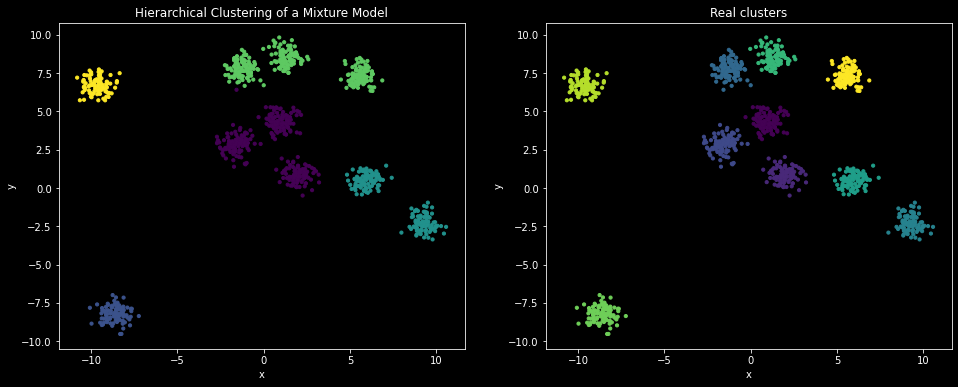

In [76]:
"""Plotting data """
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.scatter(X[:,0], X[:,1], s = 10  ,c = labels , cmap='viridis')
ax2.scatter(X[:,0], X[:,1], s = 10 , c = y_true, cmap='viridis')
ax1.set_title('Hierarchical Clustering of a Mixture Model')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax2.set_title('Real clusters')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
plt.show()